In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [98]:
df = pd.read_csv("data/consumption_temp.csv")
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

<Axes: xlabel='time'>

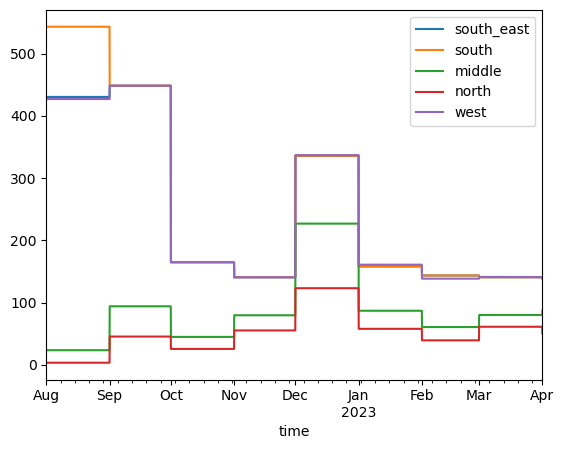

In [99]:
prices = pd.read_csv("data/prices.csv", sep=';')
prices = prices.set_index('time')
prices.index = pd.to_datetime(prices.index)
prices = prices.resample('H').ffill()
prices.plot()

In [100]:
bgo = df.query('location == "bergen"')
osl = df.query('location == "oslo"')
svg = df.query('location == "stavanger"')
tos = df.query('location == "tromsø"')
trd = df.query('location == "trondheim"')
hel = df.query('location == "helsingfors"')

In [101]:
merged = bgo.merge(prices['west'], left_index=True, right_index=True, how='outer')
start_index = merged['consumption'].notna().idxmax()
bgo = merged.loc[start_index:] 
bgo = bgo.rename(columns={"west": "price"})

In [102]:
bgo.head()

,location,consumption,temperature,price
time,,,,
2022-04-07 21:00:00,bergen,1.113325,-0.3,NaN
2022-04-07 22:00:00,bergen,1.050327,0.0,NaN
2022-04-07 23:00:00,bergen,1.008794,-0.5,NaN
2022-04-08 00:00:00,bergen,0.984202,-1.1,NaN
2022-04-08 01:00:00,bergen,0.950335,-0.7,NaN


8641
8641
8641
8641
8641
6289


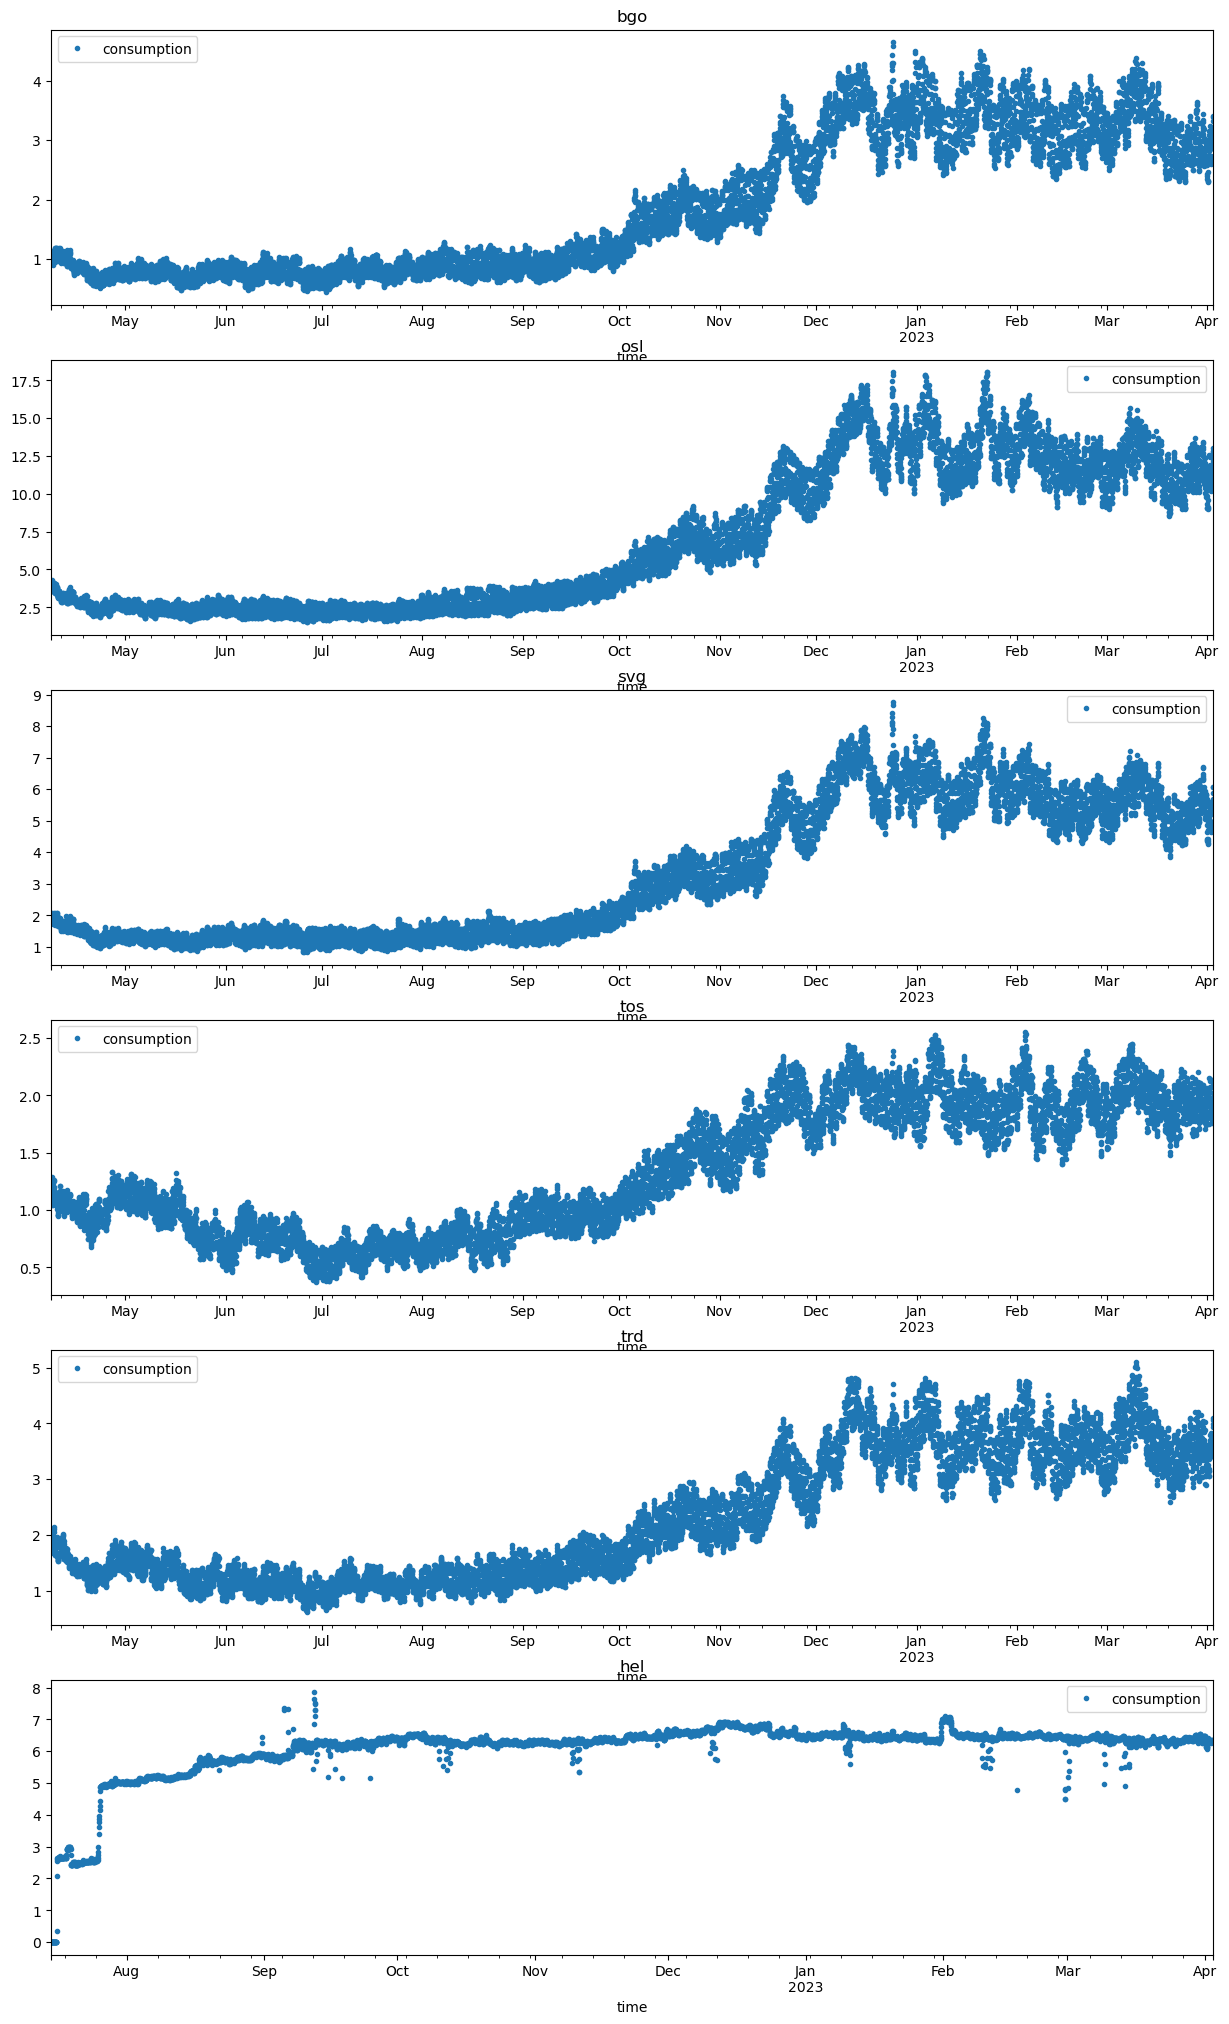

In [103]:
locations = [bgo, osl, svg, tos, trd, hel]

fig, axs = plt.subplots(6, 1, figsize=(15,25), sharex=False)
bgo[["consumption", ]].plot(ax=axs[0], title="bgo", style=".")
osl[["consumption",]].plot(ax=axs[1], title="osl", style=".")
svg[["consumption",]].plot(ax=axs[2], title="svg", style=".")
tos[["consumption", ]].plot(ax=axs[3], title="tos", style=".")
trd[["consumption",]].plot(ax=axs[4], title="trd", style=".")
hel[["consumption", ]].plot(ax=axs[5], title="hel", style=".")

for df in locations:
    print(df.shape[0])

<Axes: xlabel='time'>

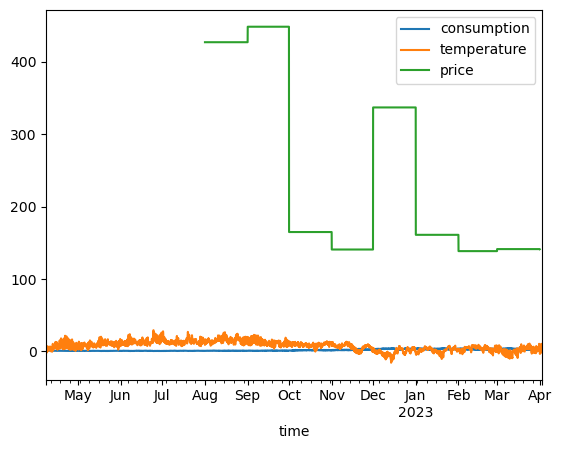

In [104]:
bgo.plot()

## Simple train/test split

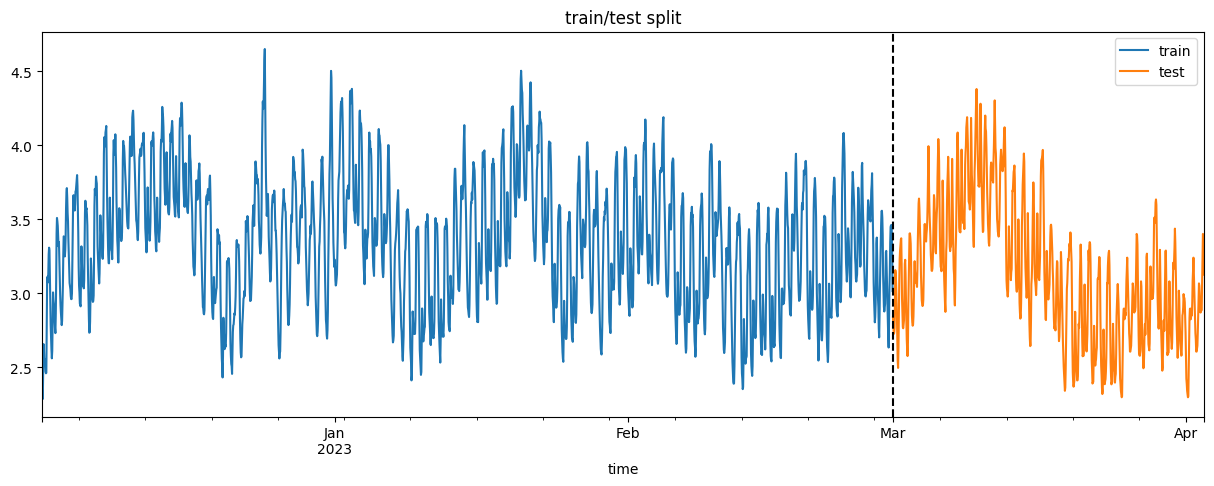

In [4]:
# only use 2023 data
bgo = bgo.query('time > "12-2022"')

train = bgo.loc[bgo.index < "03-01-2023"]
test = bgo.loc[bgo.index >= "03-01-2023"]

fig, ax = plt.subplots(figsize=(15,5))
train["consumption"].plot(ax=ax, label="train", title="train/test split")
test["consumption"].plot(ax=ax, label="test")
ax.axvline("03-01-2023", color="black", ls="--")
ax.legend(["train", "test"])
plt.show()

<Axes: title={'center': 'One week of data'}, xlabel='time'>

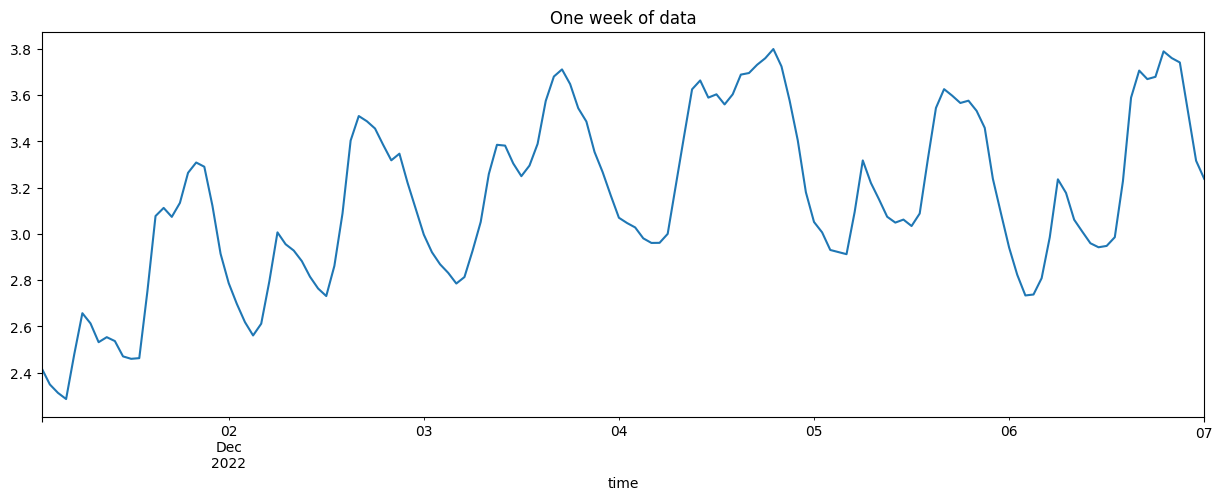

In [5]:
bgo.loc[(bgo.index > "12-01-2022") & (bgo.index <= "12-07-2022")]["consumption"].plot(
    figsize=(15,5), title="One week of data"
)

## Model Creation

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    # Creating daily lag features for up to 3 days
    for lag in range(24, 24*4, 24):
        df['lag_daily_' + str((lag))] = df['consumption'].shift(lag)
    for lag in range(24, 24*4, 24):
        df['lag_daily_' + str(lag)].dropna(inplace=True)
    # Rolling mean for the past 7 days
    df['rolling_mean_3d'] = df['consumption'].rolling(window=72).mean()
    # Rolling standard deviation for the past 3 days
    df['rolling_std_1d'] = df['consumption'].rolling(window=24).std()
    return df


In [16]:
train = bgo.loc[bgo.index < "03-01-2023"]
test = bgo.loc[bgo.index >= "03-01-2023"]

train = create_features(train)
test = create_features(test)


FEATURES = [
            'dayofyear',
            'hour',
            # 'month', 
            "temperature", 
            "lag_daily_24",
            # "lag_daily_48",
            # "lag_daily_72", 
            # 'rolling_mean_3d', 
            'rolling_std_1d'
            ]
TARGET = 'consumption'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

test.tail()


,location,consumption,temperature,prediction,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_daily_24,lag_daily_48,lag_daily_72,rolling_mean_3d,rolling_std_1d
time,,,,,,,,,,,,,,,,,
2023-04-02 17:00:00,bergen,3.183564,7.9,2.887908,17,6,2,4,2023,92,2,13,3.153503,2.994616,3.228577,2.828485,0.184193
2023-04-02 18:00:00,bergen,3.401135,5.6,3.201999,18,6,2,4,2023,92,2,13,3.240884,2.965472,3.311403,2.829731,0.199513
2023-04-02 19:00:00,bergen,3.390738,3.5,3.176892,19,6,2,4,2023,92,2,13,3.138150,2.968543,3.436975,2.829089,0.218265
2023-04-02 20:00:00,bergen,3.328194,2.5,3.269259,20,6,2,4,2023,92,2,13,3.030011,2.939289,3.342719,2.828887,0.233191
2023-04-02 21:00:00,bergen,3.126721,1.8,3.172126,21,6,2,4,2023,92,2,13,2.952498,2.838937,3.190102,2.828007,0.236754


In [8]:
reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.43413	validation_1-rmse:0.49687


[100]	validation_0-rmse:0.25474	validation_1-rmse:0.31036
[200]	validation_0-rmse:0.19632	validation_1-rmse:0.25888
[300]	validation_0-rmse:0.17457	validation_1-rmse:0.23961
[400]	validation_0-rmse:0.16305	validation_1-rmse:0.22738
[500]	validation_0-rmse:0.15415	validation_1-rmse:0.22038
[600]	validation_0-rmse:0.14784	validation_1-rmse:0.21604
[700]	validation_0-rmse:0.14298	validation_1-rmse:0.21394
[800]	validation_0-rmse:0.13917	validation_1-rmse:0.21296
[900]	validation_0-rmse:0.13613	validation_1-rmse:0.21178
[999]	validation_0-rmse:0.13306	validation_1-rmse:0.21112


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

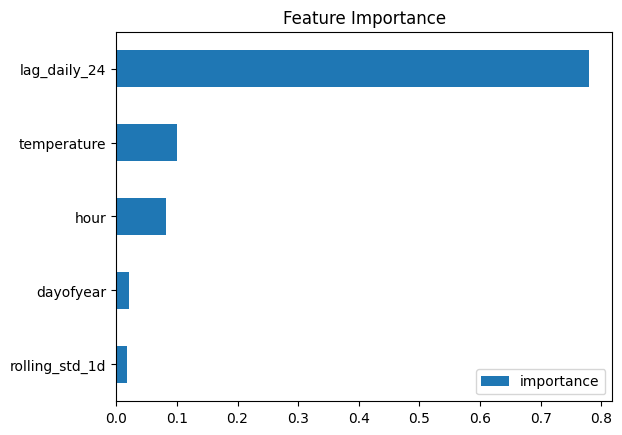

In [9]:

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

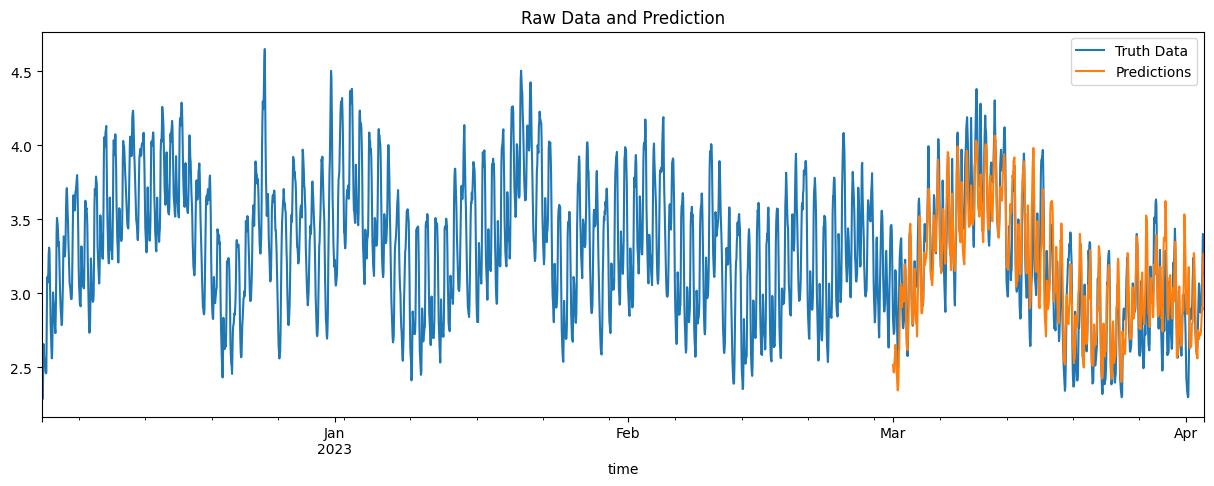

In [10]:
test['prediction'] = reg.predict(X_test)
test.head()
bgo = bgo.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = bgo[['consumption']].plot(figsize=(15, 5), style="-")
bgo['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

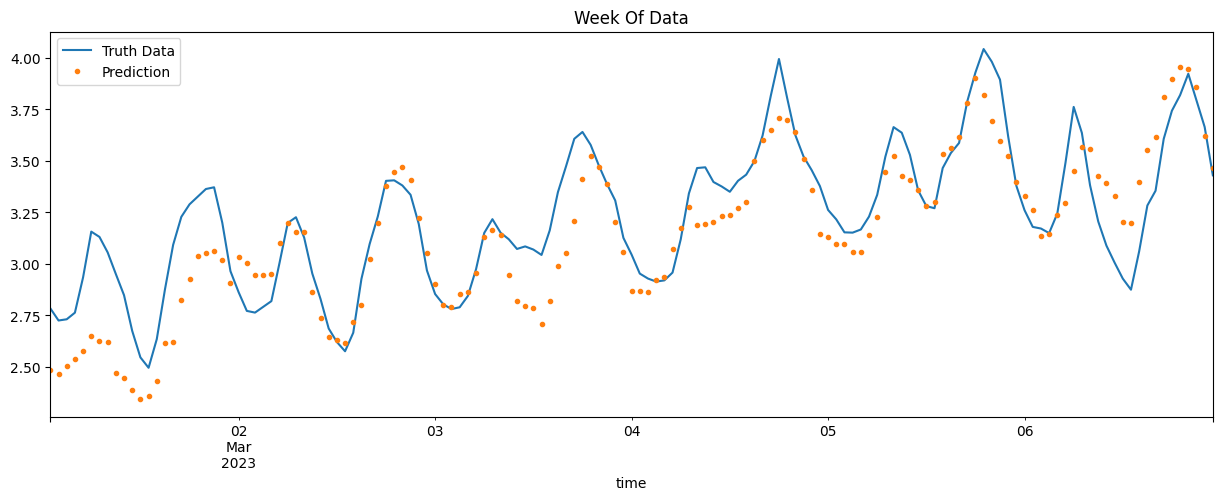

In [11]:
ax = bgo.loc[(bgo.index > '03-01-2023') & (bgo.index < '03-07-2023')]['consumption'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '03-01-2023') & (bgo.index < '03-07-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

ax = bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['consu'] \
    .plot(figsize=(15, 5), title='Week Of Data')
bgo.loc[(bgo.index > '04-01-2018') & (bgo.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [12]:
score = np.sqrt(mean_squared_error(test['consumption'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 0.21


In [13]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-04-01    0.318928
2023-03-01    0.312396
2023-03-29    0.255590
2023-03-27    0.247590
2023-03-15    0.231241
2023-03-19    0.225857
2023-03-20    0.224095
2023-03-18    0.223458
2023-03-16    0.223212
2023-03-08    0.209698
Name: error, dtype: float64